# Plan

* ~~get new data from train (if available) or old one (if not): http://otrain.org/files/xl/~~
* ~~clean the excel file: remove empty rows. english column names.~~
* ~~try to load the whole excel file~~
* ~~add time at station col~~
* ~~time in station for actual stopped True and Falses~~
* ~~more data cleanup:~~
 * ~~Remove מוצא תפעולי ויעד תפעולי~~
 * ~~On מוצא מחסחרי, remove arrival time~~
 * ~~on יעד מסחרי, remove departure time~~
 * ~~If time in station is longer than 80000, subtract number of seconds in day~~
* ~~histogram of time in station~~
* ~~Time at station planned to actual~~
* histogram for actual stop length, grouped by planned
* load and compare 2014 data
* design a measure for train latency based on daily number of passengers


In [2]:
# library for loading data and tables
# we will use it a lot, so we use its standard abbreviation - pd
import pandas as pd
import numpy as np

# plotting library
# loading it changes default styles to much nicer ones
# import seaborn as sns

# IPython Notebook option to show plots in the notebook (not in a separate window)
%matplotlib inline

In [3]:
# reading time: 1 loops, best of 3: 6min 3s per loop
df = pd.read_excel("data/otrain/2015_04_05_06.xlsx", skip_footer=400000)

In [4]:
df.count()

Train_Date             75458
Train_Number           75458
Planned                75458
Station_number         75458
Station_Description    75458
Station_Order          75458
Route_Description      75458
Station_typ            75458
Planned_Stop           60144
Actual_Stop            60130
Planned_Depratur       71000
Actual_Departure       70991
Planned_Arrival        71013
Actual_Arrival         71005
dtype: int64

In [5]:
# Show values available in these two fields
print(pd.unique(df['Planned'].ravel()))
print(pd.unique(df['Station_typ'].ravel()))

['מתוכננת' 'לא מתוכננת']
['מוצא' 'ביניים' 'יעד מסחרי' 'מוצא תפעולי' 'מוצא מסחרי' 'יעד' 'יעד תפעולי']


In [6]:
# Clean up data 
df['Planned_Stop'].fillna(0, inplace=True)
df['Actual_Stop'].fillna(0, inplace=True)
di = {'מתוכננת': True, 'לא מתוכננת': False}
df.replace({"Planned": di}, inplace=True)
df.head()

,Train_Date,Train_Number,Planned,Station_number,Station_Description,Station_Order,Route_Description,Station_typ,Planned_Stop,Actual_Stop,Planned_Depratur,Actual_Departure,Planned_Arrival,Actual_Arrival
0,2015-04-01,1,True,1600,נהריה,1,נהריה - נתבג,מוצא,1,1,2015-04-01 23:13:00,2015-04-01 23:13:52,NaT,NaT
1,2015-04-01,1,True,1500,עכו,2,נהריה - נתבג,ביניים,1,1,2015-04-01 23:23:00,2015-04-01 23:23:11,2015-04-01 23:21:00,2015-04-01 23:21:04
2,2015-04-01,1,True,800,קרית מוצקין,5,נהריה - נתבג,ביניים,1,1,2015-04-01 23:33:00,2015-04-01 23:32:08,2015-04-01 23:32:00,2015-04-01 23:31:19
3,2015-04-01,1,True,700,קרית חיים,6,נהריה - נתבג,ביניים,0,0,2015-04-01 23:36:00,2015-04-01 23:34:38,2015-04-01 23:36:00,2015-04-01 23:34:38
4,2015-04-01,1,True,1300,חוצות מפרץ,7,נהריה - נתבג,ביניים,0,0,2015-04-01 23:37:00,2015-04-01 23:35:31,2015-04-01 23:37:00,2015-04-01 23:35:31


In [7]:
df = df.rename(columns={'Station_typ': "Station_type", "Planned_Depratur": "Planned_Deprature"})
df.head()

,Train_Date,Train_Number,Planned,Station_number,Station_Description,Station_Order,Route_Description,Station_type,Planned_Stop,Actual_Stop,Planned_Deprature,Actual_Departure,Planned_Arrival,Actual_Arrival
0,2015-04-01,1,True,1600,נהריה,1,נהריה - נתבג,מוצא,1,1,2015-04-01 23:13:00,2015-04-01 23:13:52,NaT,NaT
1,2015-04-01,1,True,1500,עכו,2,נהריה - נתבג,ביניים,1,1,2015-04-01 23:23:00,2015-04-01 23:23:11,2015-04-01 23:21:00,2015-04-01 23:21:04
2,2015-04-01,1,True,800,קרית מוצקין,5,נהריה - נתבג,ביניים,1,1,2015-04-01 23:33:00,2015-04-01 23:32:08,2015-04-01 23:32:00,2015-04-01 23:31:19
3,2015-04-01,1,True,700,קרית חיים,6,נהריה - נתבג,ביניים,0,0,2015-04-01 23:36:00,2015-04-01 23:34:38,2015-04-01 23:36:00,2015-04-01 23:34:38
4,2015-04-01,1,True,1300,חוצות מפרץ,7,נהריה - נתבג,ביניים,0,0,2015-04-01 23:37:00,2015-04-01 23:35:31,2015-04-01 23:37:00,2015-04-01 23:35:31


In [8]:
# Some more cleanup. I am only interested in stations where passenger actually get on and off the train. 
# remove all rows with מוצא תפעולי ויעד תפעולי
df = df[(df["Station_type"] != 'מוצא תפעולי') & (df["Station_type"] != "יעד תפעולי")]
df.count()

Train_Date             75356
Train_Number           75356
Planned                75356
Station_number         75356
Station_Description    75356
Station_Order          75356
Route_Description      75356
Station_type           75356
Planned_Stop           75356
Actual_Stop            75356
Planned_Deprature      70943
Actual_Departure       70934
Planned_Arrival        70968
Actual_Arrival         70960
dtype: int64

In [9]:
# for מוצא מסחרי and יעד מסחרי, set departure and arrival times to NaT (respectively)
# This is important because there's a small number of rows with significinat delay in leaving the 
# commercial end point and\or in arriving to the commercial start point, which shouldn'tbe counted 
df.ix[df["Station_type"] == "יעד מסחרי", "Actual_Departure"] = pd.NaT
df.ix[df["Station_type"] == "מוצא מסחרי", "Actual_Arrival"] = pd.NaT
df[df["Station_type"] == "מוצא מסחרי"].head()


,Train_Date,Train_Number,Planned,Station_number,Station_Description,Station_Order,Route_Description,Station_type,Planned_Stop,Actual_Stop,Planned_Deprature,Actual_Departure,Planned_Arrival,Actual_Arrival
22,2015-04-01,2,True,8600,נת-בג,5,נהריה - נתבג,מוצא מסחרי,1,1,2015-04-01 00:53:00,2015-04-01 00:53:47,2015-04-01 00:50:00,NaT
64,2015-04-01,4,True,8600,נת-בג,2,נהריה - נתבג,מוצא מסחרי,1,1,2015-04-01 01:53:00,2015-04-01 01:54:18,2015-04-01 01:50:00,NaT
106,2015-04-01,6,True,8600,נת-בג,2,נהריה - נתבג,מוצא מסחרי,1,1,2015-04-01 02:53:00,2015-04-01 02:53:42,2015-04-01 02:50:00,NaT
148,2015-04-01,8,True,8600,נת-בג,2,נהריה - נתבג,מוצא מסחרי,1,1,2015-04-01 03:53:00,2015-04-01 03:53:50,2015-04-01 03:50:00,NaT
190,2015-04-01,10,True,8600,נת-בג,2,נהריה - נתבג,מוצא מסחרי,1,1,2015-04-01 04:53:00,2015-04-01 04:54:24,2015-04-01 04:50:00,NaT


In [10]:
# Calculate time and station and delays 
df["Time_At_Station"] = (df["Actual_Departure"] - df["Actual_Arrival"]) / np.timedelta64(1, 's')
df["Planned_At_Station"] = (df["Planned_Deprature"] - df["Planned_Arrival"]) / np.timedelta64(1, 's')
df["Arrival_offset"] = (df["Actual_Arrival"] - df["Planned_Arrival"]) / np.timedelta64(1, 's')
df["Departure_offset"] = (df["Actual_Departure"] - df["Planned_Deprature"]) / np.timedelta64(1, 's')

df['Time_At_Station'].fillna(0, inplace=True)
df['Planned_At_Station'].fillna(0, inplace=True)
df['Arrival_offset'].fillna(0, inplace=True)
df["Departure_offset"] = (df["Actual_Departure"] - df["Planned_Deprature"]) / np.timedelta64(1, 's')

df.head()

,Train_Date,Train_Number,Planned,Station_number,Station_Description,Station_Order,Route_Description,Station_type,Planned_Stop,Actual_Stop,Planned_Deprature,Actual_Departure,Planned_Arrival,Actual_Arrival,Time_At_Station,Planned_At_Station,Arrival_offset,Departure_offset
0,2015-04-01,1,True,1600,נהריה,1,נהריה - נתבג,מוצא,1,1,2015-04-01 23:13:00,2015-04-01 23:13:52,NaT,NaT,0,0,0,52
1,2015-04-01,1,True,1500,עכו,2,נהריה - נתבג,ביניים,1,1,2015-04-01 23:23:00,2015-04-01 23:23:11,2015-04-01 23:21:00,2015-04-01 23:21:04,127,120,4,11
2,2015-04-01,1,True,800,קרית מוצקין,5,נהריה - נתבג,ביניים,1,1,2015-04-01 23:33:00,2015-04-01 23:32:08,2015-04-01 23:32:00,2015-04-01 23:31:19,49,60,-41,-52
3,2015-04-01,1,True,700,קרית חיים,6,נהריה - נתבג,ביניים,0,0,2015-04-01 23:36:00,2015-04-01 23:34:38,2015-04-01 23:36:00,2015-04-01 23:34:38,0,0,-82,-82
4,2015-04-01,1,True,1300,חוצות מפרץ,7,נהריה - נתבג,ביניים,0,0,2015-04-01 23:37:00,2015-04-01 23:35:31,2015-04-01 23:37:00,2015-04-01 23:35:31,0,0,-89,-89


In [11]:
# Checked planned stop data. 

# Are there any planned stops that were not executed?
print(df[(df['Planned_Stop'] == 1) & (df['Actual_Stop'] == 0)].count())
# It seems to have happened 26 time 

# Are there any unplanned stops ?
print(df[(df['Planned_Stop'] == 0) & (df['Actual_Stop'] == 1)].count())
# That seems to have happened 12 times. 



Train_Date             26
Train_Number           26
Planned                26
Station_number         26
Station_Description    26
Station_Order          26
Route_Description      26
Station_type           26
Planned_Stop           26
Actual_Stop            26
Planned_Deprature      26
Actual_Departure       20
Planned_Arrival        26
Actual_Arrival         20
Time_At_Station        26
Planned_At_Station     26
Arrival_offset         26
Departure_offset       20
dtype: int64
Train_Date             12
Train_Number           12
Planned                12
Station_number         12
Station_Description    12
Station_Order          12
Route_Description      12
Station_type           12
Planned_Stop           12
Actual_Stop            12
Planned_Deprature      12
Actual_Departure       12
Planned_Arrival        12
Actual_Arrival         11
Time_At_Station        12
Planned_At_Station     12
Arrival_offset         12
Departure_offset       12
dtype: int64


In [12]:
# sanity check - when the train wasn't planned to stop, was there a planned stop time?
# when the train didn't actually stop, was there an actual stop time? 
df[(df['Planned_Stop'] == 0) & (df['Planned_At_Station'] > 0)].head()
# There's a single case on train #8135
df[df['Train_Number']==8135]

# are there trains that didn't stop but have time at station?
df[(df.Actual_Stop==0) & (df.Time_At_Station != 0)].count()
# no - this never happaned 

# in total these are not really a problem. so let's remove all the stop 0 
df = df[df.Time_At_Station > 0]

In [13]:
print (df["Time_At_Station"].max())
# The maximum value is 86590. 

86590.0


In [14]:
df[df["Time_At_Station"]>8000]

,Train_Date,Train_Number,Planned,Station_number,Station_Description,Station_Order,Route_Description,Station_type,Planned_Stop,Actual_Stop,Planned_Deprature,Actual_Departure,Planned_Arrival,Actual_Arrival,Time_At_Station,Planned_At_Station,Arrival_offset,Departure_offset
1008,2015-04-01,56,True,5000,לוד,12,נהריה - באר שבע מרכז,ביניים,1,1,2015-04-02 00:01:00,2015-04-02 23:59:59,2015-04-01 23:59:00,2015-04-01 23:57:38,86541,120,-82,86339
12735,2015-04-02,697,True,4900,תל אביב ההגנה,13,הוד השרון-שדרות,ביניים,1,1,2015-04-03 00:03:00,2015-04-03 00:02:47,2015-04-03 00:02:00,2015-04-01 23:59:59,86568,60,-86521,-13
17530,2015-04-04,7027,True,3600,תא אוניברסיטה,28,נהריה - באר שבע מרכז,ביניים,1,1,2015-04-05 00:01:00,2015-04-05 23:59:59,2015-04-04 23:59:59,2015-04-04 23:56:49,86590,61,-190,86339
26051,2015-04-06,56,True,5000,לוד,12,נהריה - באר שבע מרכז,ביניים,1,1,2015-04-07 00:01:00,2015-04-07 23:59:59,2015-04-06 23:59:00,2015-04-06 23:57:20,86559,120,-100,86339
33146,2015-04-07,56,True,5000,לוד,12,נהריה - באר שבע מרכז,ביניים,1,1,2015-04-08 00:01:00,2015-04-08 23:59:59,2015-04-07 23:59:00,2015-04-07 23:59:14,86445,120,14,86339
40243,2015-04-08,56,True,5000,לוד,12,נהריה - באר שבע מרכז,ביניים,1,1,2015-04-09 00:01:00,2015-04-09 23:59:59,2015-04-08 23:59:00,2015-04-08 23:57:38,86541,120,-82,86339
49989,2015-04-11,7027,True,3600,תא אוניברסיטה,28,נהריה - באר שבע מרכז,ביניים,1,1,2015-04-12 00:01:00,2015-04-12 23:59:59,2015-04-11 23:59:59,2015-04-11 23:57:57,86522,61,-122,86339
50282,2015-04-11,7209,True,5200,רחובות,20,בנימינה - אשקלון,ביניים,1,1,2015-04-12 00:02:00,2015-04-12 23:59:59,2015-04-11 23:59:59,2015-04-11 23:58:55,86464,121,-64,86279
52182,2015-04-12,134,True,2100,חיפה מרכז,28,נהריה - מודיעין מרכז,ביניים,1,1,2015-04-13 00:02:00,2015-04-13 23:59:59,2015-04-12 23:59:59,2015-04-12 23:59:24,86435,121,-35,86279
58563,2015-04-13,56,True,5000,לוד,12,נהריה - באר שבע מרכז,ביניים,1,1,2015-04-14 00:01:00,2015-04-14 23:59:59,2015-04-13 23:59:00,2015-04-13 23:59:37,86422,120,37,86339


There seems to be an issue where if the train is supposed to leave the station after midnight, but end up leaving before midnight, it still gets the date of the planned departure. There are 11 records that have this problem. For now I am going to just delete them.

In [15]:
df = df[df.Time_At_Station < 86000]


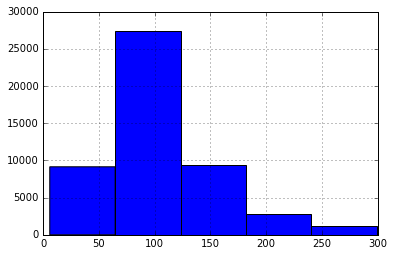

In [16]:
df[df.Time_At_Station<300]["Time_At_Station"].hist(bins=5)

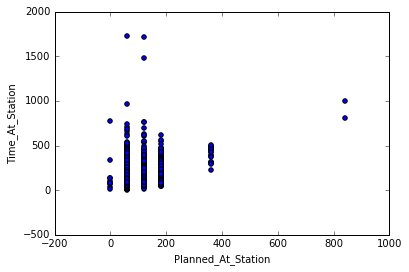

In [18]:
df.plot(kind='scatter', x='Planned_At_Station', y='Time_At_Station')
